In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
from collections import defaultdict

import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling3D, GlobalMaxPool3D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional, ConvLSTM2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
INPUT_PATH = "../content/drive/MyDrive/CK+48/"

for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    print(f"{dir_} has {count} number of images")


happy has 207 number of images
surprise has 249 number of images
sadness has 84 number of images
anger has 135 number of images
fear has 75 number of images


In [ ]:
TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

In [ ]:
INPUT_PATH = "../content/drive/MyDrive/CK+48/"

data = defaultdict(str)
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        data[dir_] = defaultdict(list)
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            sub = f.split("_")[0]
            data[dir_][sub].append(f)

# data

In [ ]:
### Processing images into array form

def preprocess_list(x):
    return int((x.split("_")[2]).split(".")[0])

def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]

def img2array(x,path):
    arr = np.empty(shape=(3,48,48))
    for i,f in enumerate(x):
        img = cv2.imread(path+f, 0)
        arr[i] = img
    return arr

In [ ]:
for emotion in data:
    data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
    data[emotion] = dict((k, img2array(v, path=INPUT_PATH + emotion + "/")) for k, v in data[emotion].items())

# data

In [ ]:
for k,v in data.items():
    print(f"{k} has {len(v)} samples")

happy has 69 samples
surprise has 83 samples
sadness has 28 samples
anger has 45 samples
fear has 25 samples


### Making a data of all images of emotions in separate array

In [ ]:
surprise = np.stack(data["surprise"].values(), axis=0)
surprise = surprise.reshape(*surprise.shape,1)

happy = np.stack(data["happy"].values(), axis=0)
happy = happy.reshape(*happy.shape,1)

anger = np.stack(data["anger"].values(), axis=0)
anger = anger.reshape(*anger.shape,1)

sadness = np.stack(data["sadness"].values(), axis=0)
sadness = sadness.reshape(*sadness.shape,1)

fear = np.stack(data["fear"].values(), axis=0)
fear = fear.reshape(*fear.shape,1)

X = np.concatenate((surprise, happy, anger, sadness, fear))
y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))
y = np_utils.to_categorical(y)

X.shape, y.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


((250, 3, 48, 48, 1), (250, 5))

### Combining all 5 array 3 times

In [ ]:
X1 = np.concatenate((surprise, happy, anger, sadness, fear,surprise, happy, anger, sadness, fear,surprise, happy, anger, sadness, fear))
y1 = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25),np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25),np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))
y1 = np_utils.to_categorical(y1)

print(X1.shape)
print(y1.shape)


(750, 3, 48, 48, 1)
(750, 5)


In [ ]:
label_emotion_mapper = {0:"surprise", 1:"happy", 2:"anger", 3:"sadness", 4:"fear"}

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, train_size=0.7, stratify=y1, shuffle=True, random_state=42)
X_train.shape, X_valid.shape

((525, 3, 48, 48, 1), (225, 3, 48, 48, 1))

In [ ]:
y_train.shape,y_valid.shape

((525, 5), (225, 5))

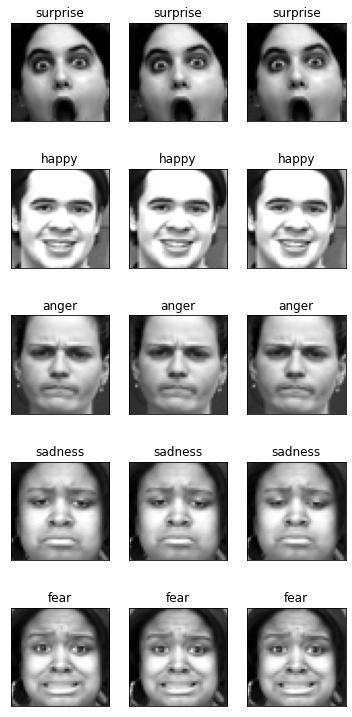

In [ ]:
np.random.seed(42)
surprise_idx = np.random.choice(np.where(y_train[:, 0]==1)[0], size=1)
happy_idx = np.random.choice(np.where(y_train[:, 1]==1)[0], size=1)
anger_idx = np.random.choice(np.where(y_train[:, 2]==1)[0], size=1)
sad_idx = np.random.choice(np.where(y_train[:, 3]==1)[0], size=1)
fear_idx = np.random.choice(np.where(y_train[:, 4]==1)[0], size=1)

fig = pyplot.figure(1, (6,13))

i = 0
for name, idx in zip(label_emotion_mapper.values(), [surprise_idx, happy_idx, anger_idx, sad_idx, fear_idx]):
    for j in range(3):
        i += 1
        ax = pyplot.subplot(5,3,i)
        sample_img = X_train[idx][0,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)

In [ ]:
# data normalization
X_train = X_train / 255.
X_valid = X_valid / 255.

X_train.shape, X_valid.shape

((525, 3, 48, 48, 1), (225, 3, 48, 48, 1))

In [ ]:
def build_convlstm(input_shape, num_class, show_summary=True):
    net = Sequential(name='ConvLSTM2D')

    net.add(
        ConvLSTM2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        ConvLSTM2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(
        MaxPooling3D(
            pool_size=(1, 2, 2),
            padding='same',
            name='maxpool3d_1'
        )
    )
    net.add(Dropout(0.3, name='dropout_1'))

    net.add(
        ConvLSTM2D(
            filters=128,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        ConvLSTM2D(
            filters=128,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(
        MaxPooling3D(
            pool_size=(1, 2, 2),
            padding='same',
            name='maxpool3d_2'
        )
    )
    net.add(Dropout(0.3, name='dropout_2'))

    net.add(
        ConvLSTM2D(
            filters=256,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        ConvLSTM2D(
            filters=256,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(
        MaxPooling3D(
            pool_size=(1, 2, 2),
            padding='same',
            name='maxpool3d_3'
        )
    )
    net.add(Dropout(0.3, name='dropout_3'))
    
    net.add(TimeDistributed(Flatten(name="flatten")))
    
    net.add(
        TimeDistributed(
            Dense(
                64,
                activation='elu',
                kernel_initializer='he_normal',
                name='dense_1'
            )
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(Dropout(.6, name="dropout_4"))

    net.add(
        TimeDistributed(
            Dense(
                num_class,
                activation='softmax',
                name='out_layer'
            )
        )
    )

    if show_summary:
        net.summary()

    return net

In [ ]:
INPUT_SHAPE = (3, 48, 48, 1)
optim = optimizers.Adam(0.001)

model = build_convlstm(INPUT_SHAPE, num_class=5)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

Model: "ConvLSTM2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convlstm2d_1 (ConvLSTM2D)    (None, 3, 48, 48, 64)     150016    
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 3, 48, 48, 64)     256       
_________________________________________________________________
convlstm2d_2 (ConvLSTM2D)    (None, 3, 48, 48, 64)     295168    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 3, 48, 48, 64)     256       
_________________________________________________________________
maxpool3d_1 (MaxPooling3D)   (None, 3, 24, 24, 64)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 24, 24, 64)     0         
_________________________________________________________________
convlstm2d_3 (ConvLSTM2D)    (None, 3, 24, 24, 128)    8

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.7,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
#     early_stopping,
    lr_scheduler,
]

batch_size = 32
epochs = 30

In [ ]:
y_train_ = np.empty((y_train.shape[0], 3, 5))
for i in range(y_train.shape[0]):
    y_train_[i] = np.tile(y_train[i], (3,1))
    
y_valid_ = np.empty((y_valid.shape[0], 3, 5))
for i in range(y_valid.shape[0]):
    y_valid_[i] = np.tile(y_valid[i], (3,1))

In [ ]:
 np.empty((y_train.shape[0], 3, 5))

array([[[ 0.00000000e+000,  5.16678635e-063,  3.45845952e-323,
          2.14327727e-312,  0.00000000e+000],
        [ 8.24694376e-319,  8.14575912e-319,  3.08888387e-315,
         -4.45242680e-004, -1.32556657e-011],
        [ 1.90533787e-001,  1.36605014e+001, -1.18209773e-005,
         -1.96385317e-019,  1.07167527e-001]],

       [[-3.12469205e-009, -1.94213072e-007, -5.98114802e-002,
         -8.23855274e-014, -1.63462940e-020],
        [ 2.64517041e-007,  8.38533393e-004,  2.37400986e-009,
          5.84564894e-006,  2.70179180e-004],
        [-1.72754170e-007, -7.56995105e+000,  2.86680997e-001,
          5.49484753e-007, -2.69193887e+000]],

       [[ 2.31062857e-001,  4.33208982e-007, -1.40874864e-011,
         -2.38238560e-011,  1.10291881e+001],
        [ 1.07414136e+003, -6.24396397e-021,  1.79614668e-004,
         -3.08564126e-001, -8.47757421e-003],
        [-7.84545301e-001,  3.16490000e-003, -3.29599047e+000,
         -3.22080096e-009, -1.72895085e-007]],

       ...,



In [ ]:
y_train_.shape, y_valid_.shape

((525, 3, 5), (225, 3, 5))

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train_,
    validation_data=(X_valid, y_valid_),
    batch_size=batch_size,
    epochs=60,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/60
17/17 [==============================] - 31s 679ms/step - loss: 2.2089 - accuracy: 0.3388 - val_loss: 1.6066 - val_accuracy: 0.3333
Epoch 2/60
17/17 [==============================] - 10s 585ms/step - loss: 0.7961 - accuracy: 0.7352 - val_loss: 1.5990 - val_accuracy: 0.2756
Epoch 3/60
17/17 [==============================] - 10s 587ms/step - loss: 0.4381 - accuracy: 0.8393 - val_loss: 1.5876 - val_accuracy: 0.2756
Epoch 4/60
17/17 [==============================] - 10s 592ms/step - loss: 0.2486 - accuracy: 0.9230 - val_loss: 1.6511 - val_accuracy: 0.1659
Epoch 5/60
17/17 [==============================] - 10s 595ms/step - loss: 0.2514 - accuracy: 0.9230 - val_loss: 1.6917 - val_accuracy: 0.1319
Epoch 6/60
17/17 [==============================] - 10s 599ms/step - loss: 0.1412 - accuracy: 0.9599 - val_loss: 1.7141 - val_accuracy: 0.1022
Epoch 7/60
17/17 [==============================] - 10s 606ms/step - loss: 0.1067 - accuracy: 0.9688 - val_loss: 1.6599 - val_accuracy: 0.1022

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

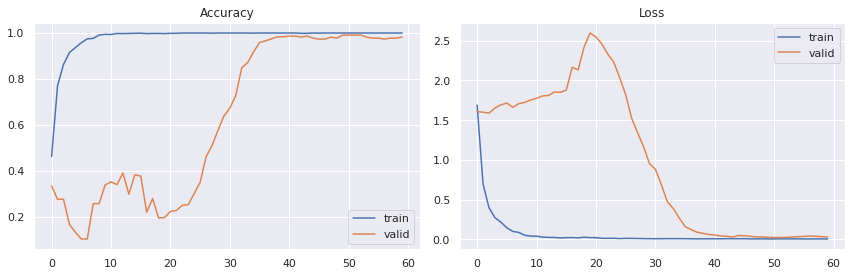

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

In [ ]:
path = "../content/drive/MyDrive/CK+48/fear/"
for dir_ in os.listdir(path):
  img = cv2.imread(path+dir_, 0)
print(img.shape)

(48, 48)


In [ ]:
from keras.models import Model, load_model

In [ ]:
model.save('./Emotion_CNN.h5')

In [ ]:
m = load_model('./Emotion_CNN.h5')

In [ ]:
m.predict(X_valid)

array([[[9.99968290e-01, 4.06999078e-07, 1.15586533e-06, 1.57862851e-05,
         1.44748319e-05],
        [9.99970436e-01, 7.38262713e-07, 2.88481397e-06, 1.25621473e-05,
         1.32944142e-05],
        [9.99961019e-01, 9.86522650e-07, 3.74797764e-06, 1.49328653e-05,
         1.92971420e-05]],

       [[5.23146753e-07, 9.99973297e-01, 5.29856652e-06, 2.89397894e-06,
         1.79831241e-05],
        [7.92584331e-07, 9.99962926e-01, 6.33664013e-06, 1.00712105e-05,
         1.97631089e-05],
        [1.30623562e-06, 9.99952078e-01, 7.59761542e-06, 1.43886755e-05,
         2.46339587e-05]],

       [[2.10752432e-06, 2.77746125e-07, 1.21948920e-04, 9.99770463e-01,
         1.05206171e-04],
        [7.48488787e-07, 6.40085773e-07, 3.22520900e-05, 9.99931097e-01,
         3.51387935e-05],
        [1.15395073e-06, 1.83811233e-06, 3.52586176e-05, 9.99904990e-01,
         5.67365132e-05]],

       ...,

       [[1.11385020e-06, 5.39614575e-07, 9.99991059e-01, 1.76428182e-06,
         5.523298